In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline  
import statsmodels.stats.power as smp

## `Power analysis`¶
We can compute a power analysis using functions from the `statsmodels.stats.power` package.  
Let’s focus on the `power for an independent samples t-test` in order to determine  
a `difference in the mean` between two groups.  
We wish to have 80% power to find the effect if it exists.  
We can compute the `sample size` needed for adequate power using the `TTestIndPower()` function.

In [3]:
# effect_size : standardized effect size, difference between the two means divided by the standard deviation. effect_size has to be positive.
# nobs1 : number of observations of sample 1. The number of observations of sample two is ratio times the size of sample 1, i.e. nobs2 = nobs1 * ratio
# alpha : significance level, e.g. 0.05, is the probability of a type I error, that is wrong rejections if the Null Hypothesis is true.
# power : power of the test, e.g. 0.8, is 1 - the probability of a type II error. Power is the probability that the test correctly rejects the Null Hypothesis if the Alternative Hypothesis is true.
# ratio : ratio of the number of observations in sample 2 relative to sample 1. see description of nobs1 The default for ratio is 1; to solve for ratio given the other arguments it has to be explicitly set to None.
# alternative : str, 'two-sided' (default), 'larger', 'smaller' : extra argument to choose whether the power is calculated for a two-sided (default) or one sided test. The one-sided test can be either 'larger', 'smaller'.

power_analysis = smp.TTestIndPower()

print(f'Sample size: {math.ceil( power_analysis.solve_power(effect_size=0.5, power=0.8, alpha=0.05, ratio= 1 ))}')
print(f'Effect size: {power_analysis.solve_power(nobs1=64, power=0.8, alpha=0.05, ratio= 1 )}')
print(f'Power : {power_analysis.solve_power(effect_size=0.5, nobs1=64,  alpha=0.05, ratio= 1 )}')
print(f'Alpha : {power_analysis.solve_power(effect_size=0.5, nobs1=64,  power=0.8,  ratio= 1 )}')
print(f'Ratio : {power_analysis.solve_power(effect_size=0.5, nobs1=64,  power=0.8,  alpha=0.05, ratio= None )}')

Sample size: 64
Effect size: 0.49906918190645305
Power : 0.8014595500498455
Alpha : 0.049407419830393415
Ratio : 0.9927022699764002


## `Power curves`¶
We can also create plots that can show us how the power to find an effect varies as a function  
of effect size and sample size, at the alpha specified in the power analysis.  
We will use the `plot_power()` function. The x-axis is defined by the `dep_var` argument,  
while sample sizes (`nobs`) and effect sizes (`effect_size`) are provided as arrays.

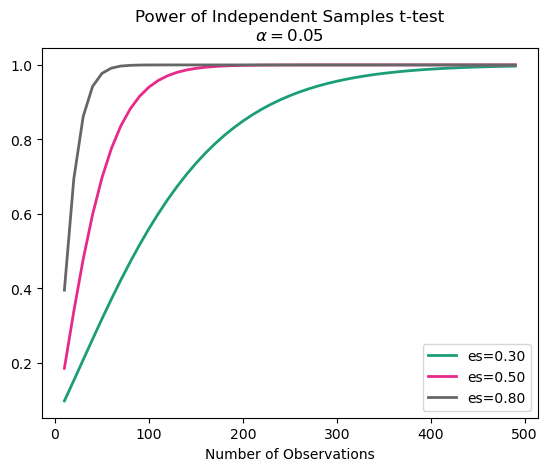

In [4]:
effect_sizes = np.array([ 0.3, 0.5, 0.8,  ])
sample_sizes = np.array(range(10, 500, 10))

# plt.style.use('seaborn')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
fig = power_analysis.plot_power(
    dep_var='nobs', # 'nobs', 'effect_size', 'alpha'
    nobs=sample_sizes,  
    effect_size=effect_sizes, 
    alpha=0.05, # The significance level (type I error) used in the power calculation. 
    ax=ax, 
    title='Power of Independent Samples t-test\n$\\alpha = 0.05$')
    

### `Webinar`
[Как и зачем оценивать размер выборки для A/B теста?](https://www.youtube.com/watch?v=2nP_gcut7SU])

In [5]:
mu_c, sigma_c, n_c = 100, 8, 16  # index `c` for `c`ontrol group
n_positive = 0
total_trials =10000
confidence = 0.9
Z = stats.norm.ppf((1 + confidence)/2 ) # two sided 

threshold = mu_c + Z * sigma_c / np.sqrt(n_c) #  Z = 1.64, SEM = 1.64 * 8 / SQRT(16) = 3.29
sem_sum = 0

for i in range(total_trials):
    daily_data_control = np.random.normal(mu_c, sigma_c, n_c)
    sem_sum += stats.sem(daily_data_control)

    if daily_data_control.mean() > threshold:
        n_positive += 1
        

# print(f'Conf. z-score: {Z}, conf. x: {threshold}, SEM: {stats.sem(daily_data_control)}')
print(f'Conf. z-score: {Z}, conf. x: {threshold}, SEM: {sem_sum / total_trials} (sigma\ n^2= {sigma_c/np.sqrt(n_c)})')
n_positive / total_trials # FPR - because daily_data_control.mean() > threshold    
# in our case (1 - 0.9) / 2 = 5 %

Conf. z-score: 1.6448536269514722, conf. x: 103.28970725390295, SEM: 1.9675243263195432 (sigma\ n^2= 2.0)


0.0484

Actually we calculate the *`error I probability`* or *`FPR`*

In [6]:
mu_c, sigma_c, n_c = 100, 8, 16
mu_experiment, sigma_experiment = 105, 8
n_positive = 0
total_trials = 5000
confidence = 0.9
Z = stats.norm.ppf((1 + confidence)/2 ) 
#  Z = 1.64, SEM = 1.64 * 8 / SQRT(16) = 3.29
threshold = mu_c + Z * sigma_c / np.sqrt(n_c) # 103.29

for i in range(total_trials):
    daily_data_control = np.random.normal(mu_experiment, sigma_experiment, n_c)
    
    if daily_data_control.mean() > threshold:
        n_positive += 1
print(f'The power of the stat test = {n_positive / total_trials:.05f}') 
# FPR - because daily_data_control.mean() > threshold    
# in our case (1 - 0.9) / 2 = 5 %

The power of the stat test = 0.80720


### $ d = \frac{\mu_{exp}-\mu_{c}}{\sqrt{\frac{\sigma_{c}^2+\sigma_{exp}^2}{2}}}$   
$d$- standardized effect size, difference between the two means (experimental & control groups) divided by the standard deviation.

In [7]:
mu_c,    sigma_c    = 100, 8
mu_experiment, sigma_experiment = 110, 8

d = (mu_experiment - mu_c) / ((sigma_c**2 + sigma_experiment**2)/2) ** 0.5
print(f'Normalized effect size: {d}')  #  1.25 - standardized effect size, 
#difference between the two means (experimental & control groups) divided by the standard deviation.

Normalized effect size: 1.25


##### `Calculate the minimum sample size with given effect, power and alpha.`

In [10]:
effect = 0.333
alpha = 0.05 # upper tail
power = 0.8
# perform power analysis
analysis = smp.TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None, ratio=1, alpha=alpha, alternative='two-sided') # ratio 'two-sided', 'larger', 'smaller'
print(f'Sample Size: {math.ceil(result)}')

Sample Size: 143


In [61]:
n_c = n_experiment = 16
total_trials = 10000
mu_c =100
mu_experiment = 105
n_negative = 0
true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0
FN, FP, TN, TP = 0,0,0,0
error1 = 0
error2 = 0

mu_exp_th = mu_experiment -  stats.norm.ppf((1+confidence)/2)* sigma_experiment / np.sqrt(n_experiment)
mu_c_th = mu_c + stats.norm.ppf((1+confidence)/2) * sigma_c / np.sqrt(n_c)

for i in range(total_trials):
    control = np.random.normal(mu_c, sigma_c, n_c)
    experiment = np.random.normal(mu_experiment, sigma_experiment, n_experiment)

# H0: mu_c = mu_experiment  (actually not TRUE)
# H1: mu_c != mu_experiment  (actually is TRUE)



    if control.mean() > mu_c_th: # error1
        
        error1 +=1
        if experiment.mean() < mu_c_th :
            error2 += 1
            FN += 1
        else:
            TN += 1

    else:  # H0 accepted
        
        if control.mean() < mu_exp_th :
            # right rejection of H0
            TP += 1    
        else:
            # wrong rejection of H0
            FP += 1



# alpha : significance level, is the probability of a type I error, that is wrong rejections if the Null Hypothesis is true.
# power : power of the test, is 1 - the probability of a type II error. Power is the probability that the test correctly rejects 
# the Null Hypothesis if the Alternative Hypothesis is true.

print(f'TP:{TP}, FN: {FN}')
print(f'FP:{FP}, TN: {TN}')
# print(f'The power of the stat TEST = { true_positives / error1}')
print(f'The power of the stat TEST = {1 - FN / (FN + TN):.05f}')
# FPR = FP/ (FP+TP)
                                                        # Beta FNR = FN/ (FN + TN)
print(f'error1 (alpha)= {(FN + TN) / total_trials:.05f}, error2 (beta)= {FN / (FN + TN ):.05f}')

print(f'{FP+FN+TP+TN}, error1: {error1}, er2_oservations: {error2}')


TP:8065, FN: 102
FP:1432, TN: 401
The power of the stat TEST = 0.79722
error1 (alpha)= 0.05030, error2 (beta)= 0.20278
10000, error1: 503, er2_oservations: 102


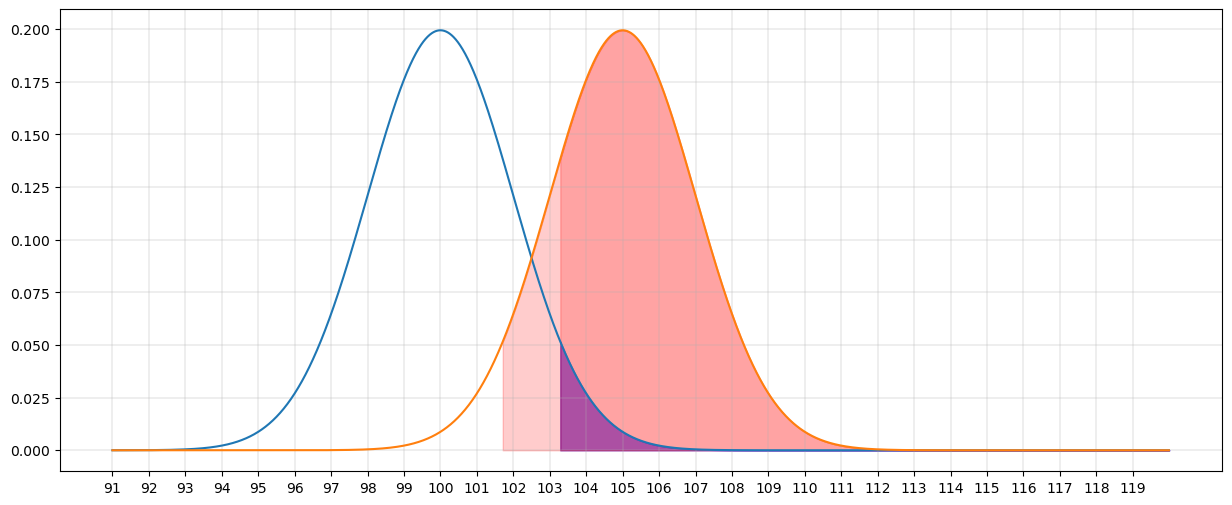

In [62]:
x_axis = np.arange(91, 120, 0.01)
y_c = stats.norm.pdf(x_axis, mu_c, sigma_c/np.sqrt(n_c))
x_c_fill = np.arange(mu_c_th, 120, 0.01)
y_c_fill = stats.norm.pdf(x_c_fill, mu_c, sigma_c/np.sqrt(n_c))

y_exp = stats.norm.pdf(x_axis, mu_experiment, sigma_experiment/np.sqrt(n_experiment))
x_exp_fill = np.arange(mu_c_th, 120, 0.01)
y_exp_fill = stats.norm.pdf(x_exp_fill, mu_experiment, sigma_experiment/np.sqrt(n_experiment))
x_exp_fill2 = np.arange(mu_exp_th, 120, 0.01)
y_exp_fill2 = stats.norm.pdf(x_exp_fill2, mu_experiment, sigma_experiment/np.sqrt(n_experiment))

fig, ax = plt.subplots(figsize=(15,6))
# plt.style.use('fivethirtyeight')
ax.plot(x_axis, y_c)
ax.plot(x_axis, y_exp)
ax.fill_between(x_c_fill, y_c_fill, 0, alpha=0.5, color='b')
ax.fill_between(x_exp_fill,y_exp_fill,0, alpha=0.2, color='r')
ax.fill_between(x_exp_fill2,y_exp_fill2,0, alpha=0.2, color='r')

ax.set_xticks(np.arange(91,120))
plt.grid(linewidth=.3)
plt.show()